In [54]:
import numpy as np
from scipy.optimize import minimize, Bounds 
from scipy.optimize import Bounds
from IPython.core.interactiveshell import InteractiveShell
import matplotlib.pyplot as plt
InteractiveShell.ast_node_interactivity = "all"
#InteractiveShell.ast_node_interactivity = "last_expr"

In [55]:
def scale_bounds(b):
    if b[1] - b[0] > 10:
        b = np.log10(b)
    c1i = (b[1] + b[0])*.5
    c2i = (b[1] - b[0])*.5
    return ((b[0] - c1i)/c2i, (b[1] - c1i)/c2i)
def unscale(p, b): 
    if b[1] - b[0] > 10:
        b = np.log10(b)
        c1i = (b[1] + b[0])*.5
        c2i = (b[1] - b[0])*.5        
        return 10**(p*c2i+c1i)
    c1i = (b[1] + b[0])*.5
    c2i = (b[1] - b[0])*.5
    return p*c2i+c1i

In [56]:
scale_bounds([10, 52])

(-1.0000000000000002, 0.9999999999999997)

In [68]:
Cmin = 1e-12
Cmax = 1e-6
Rmin = 10e2
Rmax = 10e3
Vmin = .1
Vmax = 10 
fs = 100e3 #Hertz
Ts = 1/fs  #seconds
tau=2e3*1e-8
periods = 3
samples_per_period =300
t = np.linspace(0, Ts*periods, periods*samples_per_period)
t_data=t
def voltage_response(t, R=1, C=1, V0=1):
    return V0 * (1 - np.exp(-t / (R * C)))
def cost_function(params, t, data):
    #need to unscale the params 
    R, C, V0 = params
    R = unscale(R, (Rmin, Rmax))
    C = unscale(C, (Cmin, Cmax))
    V0 = unscale(V0, (Vmin, Vmax))
    residuals = data - voltage_response(t, R, C, V0)
    return np.sum(residuals**2)



In [69]:

#subs = {R2: 10e3, R1:10e3, Vm:10, C1:.3e-9, w: 2*pi*fs}
# Initial guess for the parameters

initial_guess = [0, 0, 0]
# Observed data

V_data = 3.1*(1 - np.exp(-t_data / (tau)))   # observed voltages

result = minimize(cost_function, initial_guess, args=(t_data, V_data), bounds=([-1,1], [-1,1],[-1,1]))

estimated_R, estimated_C, estimated_V0 = result.x
print(f'R = {unscale(estimated_R, (Rmin, Rmax))}')
print(f'C = {unscale(estimated_C, (Cmin, Cmax))}')
print(f'V0 = {unscale(estimated_V0, (Vmin, Vmax))}')

R = 1926.376591305229
C = 1.0382104228785637e-08
V0 = 3.099985892661474


In [67]:
result 

      fun: 1.8838854008506886e-09
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00043776,  0.0005028 , -0.00018336])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 204
      nit: 28
     njev: 51
   status: 0
  success: True
        x: array([-0.43051762, -0.97923777, -0.39394224])

In [64]:
result.x[0]*result.x[1]

1.0

Realization - the optimize function returns a solution - but there were other solutions. 
With 3 unknowns, if I pick 1, I could plot the last two with respect to eachother. Or, A 3D plot showing the 
relationship of the last one as a function of two. 
I have not utilized constraints yet in optimation.  THe cost function above uses a known response and compares it to the model. 
Constraints are relationships amongst the parameters being optimized for, like R1*C2 = x. 

KVL and KCL are a kind of constraint too, but unless the parameters of the cost function are the branch voltages and currents, they can't be used in ```optimize``` Contraints are the circuit model equations (Tableau or MNA) because the topology is given or known.

The desired output (branch current or voltage) is some function of time that can be sketched or written down. If there is more than one desired output equation, use a combined wieghted cost function. Phase/initial conditions will effect convergence. 
Optimization won't leave degrees of freedom but will solve it entirely. 
It'll be really difficult to plot things symbollically. A chicken and egg scenario arises. It would be nice to be able to write down the circuit equations and then infer time of frequency domain behavior in symbolic terms - but


In [8]:
# Try to pick 1, plot the other 2 against each other. 
#also plot the value of the cost function vs what is swept 
#To do that, pick the 2nd, find the optimal 3rd, and plot. 
#What if it doesn't converge?
  

In [70]:
Rpick = 1926
Vp = 3.1
#def voltage_response(t, R=1, C=1, V0=1):
#    return V0 * (1 - np.exp(-t / (R * C)))

def cost_function2(params, t, data):
    #need to unscale the params 
    #already picked 1: R=Rmin,
    #then sweep the 2nd: Vo, find the third. 
    #minimize calls cost_function2 with params
    C, = params
    C = unscale(C, (Cmin, Cmax))
    residuals = data - voltage_response(t, R=Rpick, C=C, V0=Vp)
    return np.sum(residuals**2)


initial_guess = 0
# Observed data

V_data = 3.1*(1 - np.exp(-t_data / (tau)))   # observed voltages
result = minimize(cost_function2, initial_guess, args=(t_data, V_data), bounds=Bounds(-1,1))

estimated_C,= result.x
#print(f'R = {unscale(estimated_R, (Rmin, Rmax))}')
print(f'C = {unscale(estimated_C, (Cmin, Cmax))}')
#print(f'V0 = {unscale(estimated_V0, (Vmin, Vmax))}')

C = 1.0384214592831852e-08


In [71]:
result 

      fun: 1.508160234799434e-11
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.0084867])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 82
      nit: 7
     njev: 41
   status: 2
  success: False
        x: array([-0.97923355])

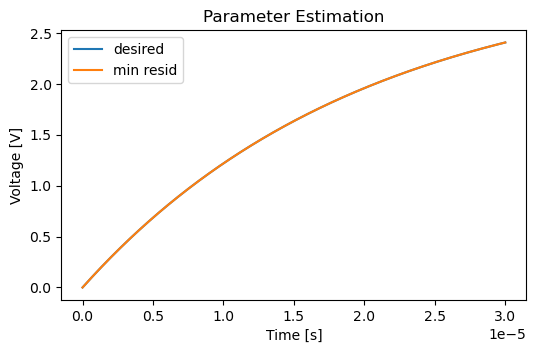

In [72]:
fig, ax = plt.subplots(subplot_kw={'title':'Parameter Estimation',
                                   'xlabel': 'Time [s]',
                                   'ylabel': 'Voltage [V]'}, figsize=(6,3.5))
ax.plot(t_data, V_data, label = 'desired' )
ax.plot(t_data, voltage_response(t, R=Rpick, C=unscale(estimated_C, (Cmin, Cmax)), V0=Vp), label='min resid')
ax.legend()

In [73]:
Rpick = 1926


#Vsweep = np.linspace(1, 5, 10)
num_sweep = 500
Vsweep=np.logspace(np.log10(Vmin), np.log10(Vmax), num_sweep)
#results = np.ndarray((num_sweep, 2))


initial_guess = 0
# Observed data

V_data = 3.1*(1 - np.exp(-t_data / (tau)))   # observed voltages
#for every V in Vsweep, there is best fit C, and a value of the cost function 
#for Vpick in Vsweep:

def my_minimize(Vpick):
    def cost_function2(params, t, data):
        #need to unscale the params 
        #already picked 1: R=Rmin,
        #then sweep the 2nd: Vo, and find the third. 
        #minimize calls cost_function2 with params
        C, = params
        C = unscale(C, (Cmin, Cmax))
        residuals = data - voltage_response(t, R=Rpick, C=C, V0=Vpick)
        return np.sum(residuals**2)    

    
    result = minimize(cost_function2, initial_guess, args=(t_data, V_data), bounds=Bounds(-1,1))
    return result.fun, unscale(result.x[0], (Cmin, Cmax))

ans = map(my_minimize, Vsweep)


In [74]:
arr = np.array(list(ans))


In [85]:
#arr

In [75]:
index = arr[:,0].argmin()

In [76]:
arr[index]

array([6.79733341e-05, 1.03689831e-08])

In [77]:
Vsweep[index]

3.0972906673314085

Text(0, 0.5, 'Best Fit Capacitance')

(1e-12, 1e-06)

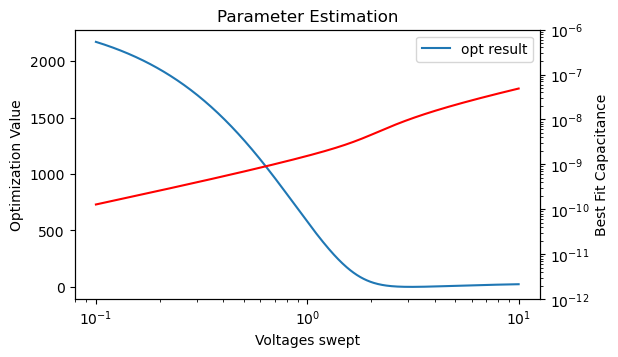

In [89]:
fig, ax = plt.subplots(subplot_kw={'title':'Parameter Estimation',
                                   'xlabel': 'Voltages swept',
                                   'ylabel': 'Optimization Value'}, figsize=(6,3.5))
ax.plot(Vsweep, arr[:,0], label = 'opt result' )
ax.set_xscale('log')
ax2 = ax.twinx() 
ax2.plot(Vsweep, arr[:,1], label='best C', color='red')
ax2.set_ylabel('Best Fit Capacitance')
ax2.set_ylim([Cmin, Cmax])
ax2.set_yscale('log')
ax.legend()